# Lightcurve Generator

Generate BBH in AGN disk model lightcurves for a given event

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns  
from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FuncFormatter
import pickle

import synphot
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from astropy.modeling.physical_models import BlackBody  
from synphot.models import Empirical1D
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot.units import PHOTLAM, FLAM


# S250328ae

In [32]:
# Define events with start times and observation MJD times
events = {
    "S250328ae": {
        "chirp_mass": 11.96 + 9.0 - 5.84 ,
        "total_mass" : 28.93 + 22.4 - 14.23,
        "dL": 511,
        "start": '2025-03-28 00:00:00',
        "obs_mjd": [60763., 60764., 60771., 60790.],
        "pfs_obs_mjd": [60768.],
        "obs_depths": {
            "decam1": {"z": 21.4, "r": 22.7, "i": 22.1},
            "decam2": {"z": 21.9, "r": 22.8, "i": 22.5},
            "decam3": {"z": 21.0, "r": 21.3, "i": 21.2},
            "decam4": {"z": 21.6, "r": 22.3, "i": 22.1},
            "pfs1": {"blue": 21.3, "red": 21.3, "nir": 19.6}
        },
    }
}


In [33]:
event_total_mass = [events[key]["total_mass"] for key in events.keys()]
event_total_mass = np.array(event_total_mass)
event_total_mass 

array([37.1])

Compute epochs wrt to event start date

In [34]:
# Compute epochs
all_epochs = {}
for event, data in events.items():
    start_time = Time(data["start"], format='iso')
    obs_times = Time(data["obs_mjd"], format='mjd')
    all_epochs[event] = (obs_times - start_time).to_value('day')

# Print results
epochs = []
for event, ep in all_epochs.items():
    epochs.append(ep)
    print(f"{event}: {ep}")

S250328ae: [ 1.  2.  9. 28.]


In [35]:
# obs depths
obs_depths = {}
for event, data in events.items():
    obs_depths[event] = data.get("obs_depths", {})
    print(f"{event}: {obs_depths[event]}")

S250328ae: {'decam1': {'z': 21.4, 'r': 22.7, 'i': 22.1}, 'decam2': {'z': 21.9, 'r': 22.8, 'i': 22.5}, 'decam3': {'z': 21.0, 'r': 21.3, 'i': 21.2}, 'decam4': {'z': 21.6, 'r': 22.3, 'i': 22.1}, 'pfs1': {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


In [36]:
epochs

[array([ 1.,  2.,  9., 28.])]

Model functions

In [37]:
def t_ram(M_BBH, kick_velocity):
    return 20 * (M_BBH / 100) * (kick_velocity / 200)**(-3) # there is another exp in terms of G, Mbbh and vk but this is correct too

def t_diff(M_SMBH, aspect_ratio, height, optical_depth):
    diffusion_time = (
        8
        * (optical_depth / 100)
        * ( height / (aspect_ratio * 0.01))
        * (aspect_ratio / 700)
        * (M_SMBH / 10**8)
    )
    return diffusion_time

def t_end(M_SMBH, kick_velocity, a, aspect_ratio, theta):
    time_end = (
        67 
        * (kick_velocity / 200)**(-1) 
        * (a / 700) 
        * (M_SMBH / 10**8)
        * (aspect_ratio / 0.01)
        * (1 / np.sin(theta / 60))
    )
    return time_end

def L_BHL(M_BBH , kick_velocity, density, radiative_efficiency):
    lumi = (
        2.5 * 10**45
        * (radiative_efficiency / 0.1)
        * (M_BBH / 100)**2
        * ((kick_velocity+50) / 200)**(-3)
        * (density / 10**(-10))
    )
    return lumi

def t_exit(height, mp_optical_depth, kick_velocity):
    return (height * np.sqrt(2 * np.log(mp_optical_depth))) / kick_velocity


## Calculations

Parameters:
- Kick Velocity (vk)
- Disk Density (rho)
- Height of the disk (height) 
- Merger Point Optical Depth (mp_optical_depth)
- Angle at which BH is kicked wrt disk plane (theta)
- Mass of SMBH 
- Radiative Efficiency


Note: Most important parameters here are kick velocity and density as they play a role in start and peak of the signature. Other params mostly affect the aftermath of the peak.

In [38]:
# Specific kick configurations

vk1 = 200 
vk2 = 300
vk3 = 1000
vk4 = 400

# Density of the disk
density = 10**(-10) #10**(-7) for testing

# t_delay for emergence of EM signal
sig_start_times_1 = t_ram(event_total_mass, vk1)  # in days

sig_start_times_2 = t_ram(event_total_mass, vk2) #* 24  # in hours

sig_start_times_3 = t_ram(event_total_mass, vk3) #* 24  # in hours

sig_start_times_4 = t_ram(event_total_mass, vk4) #* 24  # in hours

# Diffusion time scale

# diffusion timescale for EM signal to emerge

mass_SMBH =  10**8 # depends on the mass of the SMBH
a = 700 # rg
aspect_ratio = 0.01
height = a * aspect_ratio #np.random.uniform(0.001, 0.1, 1)
optical_depth = 100

diff_times = t_diff(mass_SMBH, a, height, optical_depth)
#print('Diffusion timescale:', diff_times)

# peak times

peak_time_1 = 2 * sig_start_times_1
peak_time_2 = 2 * sig_start_times_2
peak_time_3 = 2 * sig_start_times_3
peak_time_4 = 2 * sig_start_times_4

# Peak luminosities
radiative_efficiency = 0.1

peak_luminosity_1 = L_BHL(event_total_mass, vk1, density, radiative_efficiency)
peak_luminosity_2 = L_BHL(event_total_mass, vk2, density, radiative_efficiency)
peak_luminosity_3 = L_BHL(event_total_mass, vk3, density, radiative_efficiency)
peak_luminosity_4 = L_BHL(event_total_mass, vk4, density, radiative_efficiency)
print('Peak luminosities:', peak_luminosity_1, peak_luminosity_2, peak_luminosity_3, peak_luminosity_4)

# End times

# end time for EM signal

theta = 60 # np.array([10, 60, 90]) # three different angles at which the BH could be kicked # we will take 60 degrees for plotting

end_times_1 = t_end(mass_SMBH, vk1, a, aspect_ratio, theta)
end_times_2 = t_end(mass_SMBH, vk2, a, aspect_ratio, theta)
end_times_3 = t_end(mass_SMBH, vk3, a, aspect_ratio, theta)
end_times_4 = t_end(mass_SMBH, vk4, a, aspect_ratio, theta)
print(end_times_1)
print(end_times_2)
print(end_times_3)
print(end_times_4)

print('Signal start times:', sig_start_times_1, sig_start_times_2, sig_start_times_3, sig_start_times_4)

Peak luminosities: [1.7618048e+44] [6.42057143e+43] [2.37798942e+42] [3.0209273e+43]
79.62247208713413
53.081648058089414
15.924494417426825
39.811236043567064
Signal start times: [7.42] [2.19851852] [0.05936] [0.9275]


Lightcurves

In [39]:
# Define the light curve model
'''def gaussian_rise(rise_array, peak_lumi):
    t = rise_array 
    tg = rise_array[-1] - rise_array[0]
    t0 = rise_array[-1]
    return peak_lumi * np.exp(-((t - t0) ** 2) / (2 * tg ** 2))'''

def gaussian_rise(rise_array, peak_lumi):
    t = rise_array
    t0 = t[-1]                 # peak at end
    tg = t0 - t[0]             # width
    start_val = np.exp(-((t[0] - t0)**2) / (2 * tg**2))
    return peak_lumi * (np.exp(-((t - t0)**2) / (2 * tg**2)) - start_val) / (1 - start_val)


'''def exponential_decay(fall_array, peak_lumi):
    t = fall_array 
    t0 = fall_array[0]
    te = fall_array[-1] - fall_array[0]
    return peak_lumi * np.exp(-(t - t0) / te)'''

def exponential_decay(fall_array, peak_lumi):
    t = fall_array
    t0 = t[0]
    t_end = t[-1]
    te = t_end - t0
    # Normalized so f(t0)=peak_lumi, f(t_end)=0
    return peak_lumi * (np.exp(-(t - t0) / te) - np.exp(-(t_end - t0) / te)) / (1 - np.exp(-(t_end - t0) / te))


def light_curve_model(times, peak_lumi):
    # Split the time array into rise and fall arrays
    rise_times = np.linspace(times[0], times[1], 100)
    fall_times = np.linspace(times[1], times[2], 100)

    rise_lumis = gaussian_rise(rise_times, peak_lumi)
    fall_lumis = exponential_decay(fall_times, peak_lumi)
    
    return rise_times, fall_times, rise_lumis, fall_lumis


Solar SED: Use solar magnitudes to obtain griz band mags

In [40]:
# Constants
L_sun = 3.828e33  # Solar luminosity in erg/s
M_sun = {"g": 5.12, "r": 4.64, "i": 4.53, "z": 4.50}  # Solar absolute magnitudes

# Extract distance for each event
dLs = np.array([events[key]["dL"] for key in events.keys()])  

# Function to convert luminosity to absolute magnitude
def luminosity_to_mag(L, band):
    return M_sun[band] - 2.5 * np.log10(L / L_sun)

# Function to convert absolute magnitude to apparent magnitude
def absolute_to_apparent_mag(M_band, d_L):
    return M_band + 5 * np.log10(d_L) + 25

def luminosity_to_apparant_mag(L, d_L, band):
    M_band = luminosity_to_mag(L, band)
    return absolute_to_apparent_mag(M_band, d_L)


'''# Compute magnitudes for each band
mags = {}

for band in ["g", "r", "i", "z"]:
    # Compute absolute magnitudes per event
    M_band = luminosity_to_mag(L, band)
    
    # Compute apparent magnitudes per event
    mags[band] = absolute_to_apparent_mag(M_band, dLs)

#print("Apparent Magnitudes (griz bands):", mags)'''

'# Compute magnitudes for each band\nmags = {}\n\nfor band in ["g", "r", "i", "z"]:\n    # Compute absolute magnitudes per event\n    M_band = luminosity_to_mag(L, band)\n    \n    # Compute apparent magnitudes per event\n    mags[band] = absolute_to_apparent_mag(M_band, dLs)\n\n#print("Apparent Magnitudes (griz bands):", mags)'

Blackbody SED: Use blackbody approximation for SED

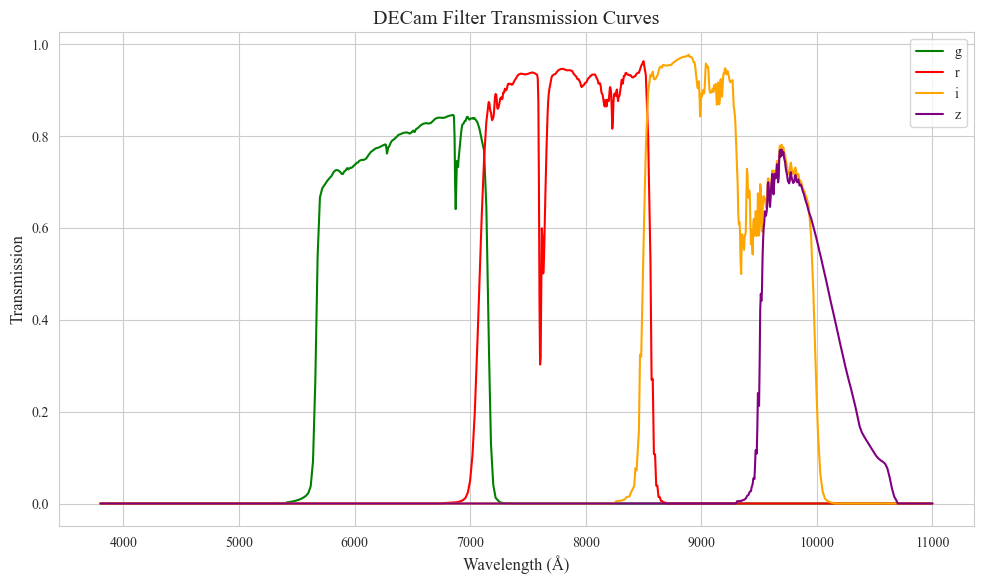

In [41]:
bandpasses = np.loadtxt('decam_transmission_curves.txt', skiprows=1)

wav = bandpasses[:,0] * u.AA  # Wavelengths in Angstroms
filter_g = bandpasses[:,2]
filter_r = bandpasses[:,3]
filter_i = bandpasses[:,4]
filter_z = bandpasses[:,5]

# Ensure wavelength is sorted
sort_idx = np.argsort(wav)
wav = wav[sort_idx]
filter_g = filter_g[sort_idx]
filter_r = filter_r[sort_idx]
filter_i = filter_i[sort_idx]
filter_z = filter_z[sort_idx]

area = np.pi * (2 * u.m) ** 2

# Plot the transmission curves
plt.figure(figsize=(10, 6))
plt.plot(wav, filter_g, label='g', color='green')
plt.plot(wav, filter_r, label='r', color='red')
plt.plot(wav, filter_i, label='i', color='orange')
plt.plot(wav, filter_z, label='z', color='purple')

plt.xlabel('Wavelength (Å)')
plt.ylabel('Transmission')
plt.title('DECam Filter Transmission Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
bp_g = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_g),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_r = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_r),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_i = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_i),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_z = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_z),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
filters = {'g': bp_g, 'r': bp_r, 'i': bp_i, 'z': bp_z}

In [43]:
wav_grid = np.linspace(3000, 11000, 2000) * u.AA  # DECam wavelength range

In [44]:
def effective_temperature(kick_velocity):
    return 10**5 * (kick_velocity / 100)**2

For a given kick velocity, we have a flare temperature.

The radius of the flare can be calculated by using the relationship between luminosity of the backbody and temperature.

The luminosity varies as the flare evolves for the given kick velocity.

In [45]:
def compute_bb_mags(luminosities, kick_velocity, luminosity_distance):
    temperature = effective_temperature(kick_velocity)
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm?
    radius = radius * u.cm.to(u.m) * u.m  # convert to meters
    #print(f'Radius: {radius}')
    redshift = z_at_value(cosmo.luminosity_distance, luminosity_distance)
    #print(f"Redshift for dL={luminosity_distance.to(u.Mpc):.2f} is z={redshift:.3f}")
    # ensure plain float
    redshift = float(redshift)
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2 * 1/(1 + redshift)
    #print(f'Factors: {factors.shape}')
    results = []

    for F in factors:
        sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature) * F
        flux = sp_bb(wav_grid)  
        model = Empirical1D(points=wav_grid.value,     
                        lookup_table=flux.value)   
        sp_resampled = SourceSpectrum(model,
                                wave_unit=wav_grid.unit,   
                                flux_unit=flux.unit)
        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Kick velocity (km/s)': kick_velocity, 'T_eff (K)': temperature, **mags})

    df = pd.DataFrame(results)
    #print(df)

    return df

In [46]:
def compute_bb_mags_fast(luminosities, kick_velocity, luminosity_distance):
    # Compute temperature and radius
    temperature = effective_temperature(kick_velocity)  # scalar
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm
    radius = radius * u.cm.to(u.m) * u.m
    redshift = float(z_at_value(cosmo.luminosity_distance, luminosity_distance))

    # scaling factors for apparent flux
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2 * 1/(1 + redshift)

    # Evaluate blackbody flux once
    sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature)
    flux_bb = sp_bb(wav_grid)  # PHOTLAM

    # Vectorized flux scaling
    flux_scaled = flux_bb.value[None, :] * factors[:, None]  # shape: (N_events, N_wavelengths)
    N_events = flux_scaled.shape[0]

    results = []

    for i in range(N_events):
        # Wrap into SourceSpectrum for synphot once per event
        sp_resampled = SourceSpectrum(
            Empirical1D(points=wav_grid.value, lookup_table=flux_scaled[i]),
            wave_unit=wav_grid.unit,
            flux_unit=flux_bb.unit
        )

        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Luminosities': luminosities[i], 'Kick velocity (km/s)': kick_velocity,
                        'T_eff (K)': temperature, **mags})

    return pd.DataFrame(results)

QSO SED

In [47]:

# PFS band definitions (in Angstroms)# Load DECam filter transmission data
bandpasses = np.loadtxt('decam_transmission_curves.txt', skiprows=1)
wav = bandpasses[:, 0] * u.AA  # Wavelengths in Angstroms
filter_g = bandpasses[:, 2]
filter_r = bandpasses[:, 3]
filter_i = bandpasses[:, 4]
filter_z = bandpasses[:, 5]

# Ensure wavelength is sorted
sort_idx = np.argsort(wav)
wav = wav[sort_idx]
filter_g = filter_g[sort_idx]
filter_r = filter_r[sort_idx]
filter_i = filter_i[sort_idx]
filter_z = filter_z[sort_idx]



pfs_bands = {
    'PFS Blue': {'range': (3800, 6500), 'cwl': 5150, 'color': 'dodgerblue'},
    'PFS Red': {'range': (6300, 9700), 'cwl': 8000, 'color': 'crimson'},
    'PFS NIR': {'range': (9400, 12600), 'cwl': 11000, 'color': 'brown'}
}



In [48]:
# Compute effective wavelength for each filter (in Angstroms)
def effective_wavelength(wav, trans):
    return np.trapz(wav * trans, wav) / np.trapz(trans, wav)

lam_eff_g = effective_wavelength(wav.value, filter_g)
lam_eff_r = effective_wavelength(wav.value, filter_r)
lam_eff_i = effective_wavelength(wav.value, filter_i)
lam_eff_z = effective_wavelength(wav.value, filter_z)

print(f"Effective wavelengths (Å):")
print(f"  DECam g: {lam_eff_g:.2f}")
print(f"  DECam r: {lam_eff_r:.2f}")
print(f"  DECam i: {lam_eff_i:.2f}")
print(f"  DECam z: {lam_eff_z:.2f}")

Effective wavelengths (Å):
  DECam g: 6432.06
  DECam r: 7826.68
  DECam i: 9178.95
  DECam z: 9899.65


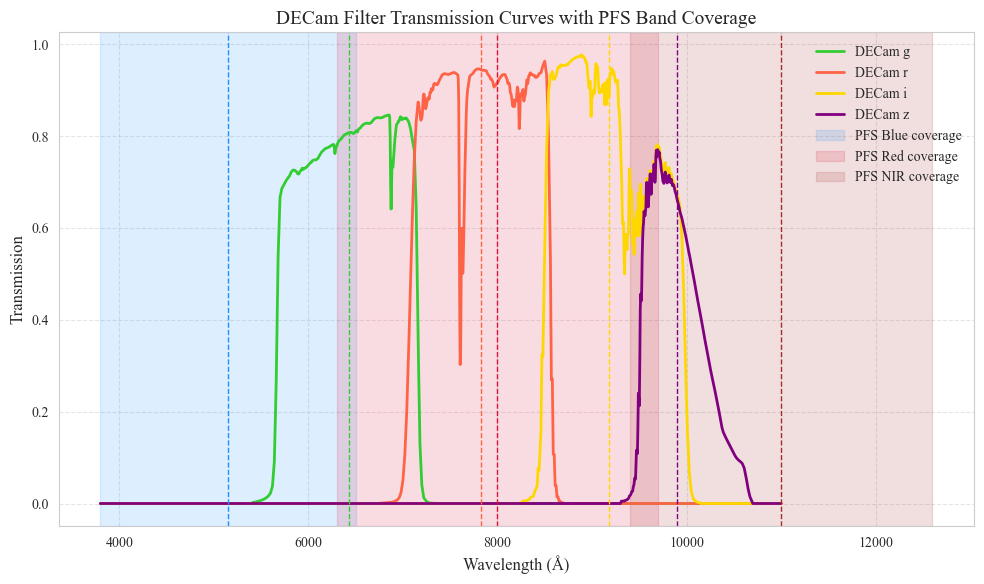

In [49]:
# Plot DECam transmission curves
plt.figure(figsize=(10, 6))
plt.plot(wav, filter_g, label='DECam g', color='limegreen', lw=2)
plt.plot(wav, filter_r, label='DECam r', color='tomato', lw=2)
plt.plot(wav, filter_i, label='DECam i', color='gold', lw=2)
plt.plot(wav, filter_z, label='DECam z', color='purple', lw=2)

# Plot CWL for Decam filters
plt.axvline(lam_eff_g, color='limegreen', ls='--', lw=1)
plt.axvline(lam_eff_r, color='tomato', ls='--', lw=1)
plt.axvline(lam_eff_i, color='gold', ls='--', lw=1)
plt.axvline(lam_eff_z, color='purple', ls='--', lw=1)

# Add shaded regions for PFS arms
for name, info in pfs_bands.items():
    x_min, x_max = info['range']
    plt.axvspan(x_min, x_max, color=info['color'], alpha=0.15, label=f"{name} coverage")
    plt.axvline(info['cwl'], color=info['color'], ls='--', lw=1)

# Plot formatting
plt.xlabel('Wavelength (Å)', fontsize=12)
plt.ylabel('Transmission', fontsize=12)
plt.title('DECam Filter Transmission Curves with PFS Band Coverage', fontsize=14)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [50]:
L_bol = np.array([[1e45]]) * u.erg / u.s
print(f"L_bol shape: {L_bol.shape}")

# Source distance
dL = events["S250328ae"]["dL"] * u.Mpc
dL = dL.to(u.cm)

# Redshift
z = z_at_value(cosmo.luminosity_distance, dL)
#dL = 2418.6 * u.Mpc . to(u.cm) #cosmo.luminosity_distance(z)
print(f"Redshift z = {z:.3f}")
#print(f"Source distance dL = {dL.to(u.Mpc):.2f}")

# Effective wavelengths (Å)
eff_wavelengths = {
    'DECam_g': lam_eff_g,
    'DECam_r': lam_eff_r,
    'DECam_i': lam_eff_i,
    'DECam_z': lam_eff_z,
    'PFS_blue': 5150,
    'PFS_red': 8000,
    'PFS_NIR': 11000,
    'ZTF_g': 4746.48,

}

# Runnoe et al. (2012) correction factors
runnoe_coeffs = {
    1450: {'C': 4.2},
    3000: {'C': 5.2},
    5100: {'C': 8.1},
}

def L_lambda_from_Lbol(Lbol, lam_eff):
    """Compute λLλ from Lbol using nearest Runnoe correction factor."""
    ref_wavelength = min(runnoe_coeffs.keys(), key=lambda w: abs(w - lam_eff))
    C = runnoe_coeffs[ref_wavelength]['C']
    return Lbol / C  # λLλ in erg/s

# Constants
c = 2.99792458e18  # speed of light in Å/s

# To Store results
magnitudes = {band: np.zeros(L_bol.shape) for band in eff_wavelengths.keys()}

# Main computation
for i in range(L_bol.shape[0]):      
    for j in range(L_bol.shape[1]):  
        Lbol = L_bol[i, j]

        for band, lam in eff_wavelengths.items():
            # λLλ (erg/s)
            L_lam = L_lambda_from_Lbol(Lbol, lam)

            # Lν (erg/s/Hz)
            L_nu = L_lam * (lam / c)

            # Fν at Earth (erg/s/cm²/Hz)
            F_nu = L_nu / (4 * np.pi * dL**2 * (1 + z))
            print(F_nu)

            # AB magnitude
            m_AB = -2.5 * np.log10(F_nu.value) - 48.6

            # Store result
            magnitudes[band][i, j] = m_AB

print("Estimated observed AB magnitudes (DECam + PFS):")
for band, mags in magnitudes.items():
    print(f"{band:10s}  mean={np.nanmean(mags):6.2f}  min={np.nanmin(mags):6.2f}  max={np.nanmax(mags):6.2f}")

rows = []
for i in range(L_bol.shape[0]):
    for j in range(L_bol.shape[1]):
        row = {'event': i, 'sample': j}
        for band in magnitudes.keys():
            row[band] = magnitudes[band][i, j]
        rows.append(row)

mag_df = pd.DataFrame(rows)
print("\nDataFrame shape:", mag_df.shape)
mag_df

L_bol shape: (1, 1)
Redshift z = 0.107 redshift
7.659162523496466e-27 erg / (s cm2)
9.319843393433166e-27 erg / (s cm2)
1.093009665127172e-26 erg / (s cm2)
1.1788292376433172e-26 erg / (s cm2)
6.1325097740487176e-27 erg / (s cm2)
9.526228775221309e-27 erg / (s cm2)
1.3098564565929303e-26 erg / (s cm2)
5.652006794626555e-27 erg / (s cm2)
Estimated observed AB magnitudes (DECam + PFS):
DECam_g     mean= 16.69  min= 16.69  max= 16.69
DECam_r     mean= 16.48  min= 16.48  max= 16.48
DECam_i     mean= 16.30  min= 16.30  max= 16.30
DECam_z     mean= 16.22  min= 16.22  max= 16.22
PFS_blue    mean= 16.93  min= 16.93  max= 16.93
PFS_red     mean= 16.45  min= 16.45  max= 16.45
PFS_NIR     mean= 16.11  min= 16.11  max= 16.11
ZTF_g       mean= 17.02  min= 17.02  max= 17.02

DataFrame shape: (1, 10)


,event,sample,DECam_g,DECam_r,DECam_i,DECam_z,PFS_blue,PFS_red,PFS_NIR,ZTF_g
0,0,0,16.689547,16.476478,16.30344,16.221373,16.930904,16.452697,16.106941,17.019493


In [51]:
def mags_from_Lbol(L_bol_array, lam_eff, dL_cm, z):
    """Return AB magnitude array for a given band."""
    # 1. λLλ (erg/s)
    L_lam = L_lambda_from_Lbol(L_bol_array, lam_eff)
    
    # 2. Lν = Lλ * (λ / c)
    L_nu = L_lam * (lam_eff / c)
    
    # 3. Fν = Lν / (4π dL²)
    F_nu = L_nu / (4 * np.pi * dL_cm**2 * (1 + z))
    
    # 4. Convert to AB magnitude
    m_AB = -2.5 * np.log10(F_nu.value) - 48.6
    return m_AB

lam_i = eff_wavelengths['DECam_i']
lam_g = eff_wavelengths['DECam_g']
lam_r = eff_wavelengths['DECam_r']
lam_z = eff_wavelengths['DECam_z']
lam_pfs_blue = eff_wavelengths['PFS_blue']
lam_pfs_red = eff_wavelengths['PFS_red']
lam_pfs_nir = eff_wavelengths['PFS_NIR']

m_i = mags_from_Lbol(L_bol, lam_i, dL, z)
m_g = mags_from_Lbol(L_bol, lam_g, dL, z)
m_r = mags_from_Lbol(L_bol, lam_r, dL, z)
m_z = mags_from_Lbol(L_bol, lam_z, dL, z)
m_pfs_blue = mags_from_Lbol(L_bol, lam_pfs_blue, dL, z)
m_pfs_red = mags_from_Lbol(L_bol, lam_pfs_red, dL, z)
m_pfs_nir = mags_from_Lbol(L_bol, lam_pfs_nir, dL, z)

print(m_i[:5])

[[16.30343999]]


# Lightcurves

With customizations specifically for PFS-DESGW paper

In [52]:
# pfs epochs
pfs_epochs = {}
for event, data in events.items():
    if "pfs_obs_mjd" in data:  # check key exists
        start_time = Time(data["start"], format='iso')
        pfs_obs_times = Time(data["pfs_obs_mjd"], format='mjd')
        pfs_epochs[event] = (pfs_obs_times - start_time).to_value('day')

# Print results
pfs_epochs_list = []
for event, ep in pfs_epochs.items():
    pfs_epochs_list.append(ep)
    print(f"{event}: {ep}")

pfs_epochs_list , pfs_epochs

S250328ae: [6.]


([array([6.])], {'S250328ae': array([6.])})

In [53]:
'''values_decam = [
    {"z": 21.4, "r": 22.7, "i": 22.1},
    {"z": 21.9, "r": 22.8, "i": 22.5},
    {"z": 21.0, "r": 21.3, "i": 21.2},
    {"z": 21.6, "r": 22.3, "i": 22.1},
]'''
#The $3\sigma$ limiting magnitudes of variability for detected transients in the DECam observations 
values_decam = [
    {"z": 23.4, "r": 23.8, "i": 23.5},
    {"z": 23.4, "r": 23.8, "i": 23.5},
    {"z": 23.4, "r": 23.8, "i": 23.5},
    {"z": 23.4, "r": 23.8, "i": 23.5},
]
values_pfs = [
    {"blue": 21.3, "red": 21.3, "nir": 19.6}
]
obs_depths_decam = dict(zip(epochs[-1], values_decam))
obs_depths_pfs = dict(zip(pfs_epochs_list[-1], values_pfs))
print("DECam Depths:", obs_depths_decam)
print("PFS Depths:", obs_depths_pfs)

DECam Depths: {1.0: {'z': 23.4, 'r': 23.8, 'i': 23.5}, 2.0: {'z': 23.4, 'r': 23.8, 'i': 23.5}, 9.0: {'z': 23.4, 'r': 23.8, 'i': 23.5}, 28.0: {'z': 23.4, 'r': 23.8, 'i': 23.5}}
PFS Depths: {6.0: {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


PLot lightcurves

In [54]:
%%time
sns.set_style("whitegrid")  

i = 0
event = list(events.keys())[0]
print(event) 
    

times_1 = np.array([sig_start_times_1[i], peak_time_1[i], end_times_1])
times_2 = np.array([sig_start_times_2[i], peak_time_2[i], end_times_2])
times_3 = np.array([sig_start_times_3[i], peak_time_3[i], end_times_3])
times_4 = np.array([sig_start_times_4[i], peak_time_4[i], end_times_4])

t_rise_1, t_fall_1, lumi_rise_1, lumi_fall_1 = light_curve_model(times_1, peak_luminosity_1)
t_rise_2, t_fall_2, lumi_rise_2, lumi_fall_2 = light_curve_model(times_2, peak_luminosity_2)
t_rise_3, t_fall_3, lumi_rise_3, lumi_fall_3 = light_curve_model(times_3, peak_luminosity_3)
t_rise_4, t_fall_4, lumi_rise_4, lumi_fall_4 = light_curve_model(times_4, peak_luminosity_4)

#print(t_rise_1.shape, t_fall_1.shape, lumi_rise_1.shape, lumi_fall_1.shape)

# Blackbody SED for flare mags
'''mag_rise_1_g = compute_bb_mags_fast(lumi_rise_1, vk1, dLs[i] * u.Mpc)['g'].to_numpy()
mag_fall_1_g = compute_bb_mags_fast(lumi_fall_1, vk1, dLs[i] * u.Mpc)['g'].to_numpy()
mag_rise_1_r = compute_bb_mags_fast(lumi_rise_1, vk1, dLs[i] * u.Mpc)['r'].to_numpy()
mag_fall_1_r = compute_bb_mags_fast(lumi_fall_1, vk1, dLs[i] * u.Mpc)['r'].to_numpy()
mag_rise_1_i = compute_bb_mags_fast(lumi_rise_1, vk1, dLs[i] * u.Mpc)['i'].to_numpy()
mag_fall_1_i = compute_bb_mags_fast(lumi_fall_1, vk1, dLs[i] * u.Mpc)['i'].to_numpy()
mag_rise_1_z = compute_bb_mags_fast(lumi_rise_1, vk1, dLs[i] * u.Mpc)['z'].to_numpy()
mag_fall_1_z = compute_bb_mags_fast(lumi_fall_1, vk1, dLs[i] * u.Mpc)['z'].to_numpy()

mag_rise_2_g = compute_bb_mags_fast(lumi_rise_2, vk2, dLs[i] * u.Mpc)['g'].to_numpy()
mag_fall_2_g = compute_bb_mags_fast(lumi_fall_2, vk2, dLs[i] * u.Mpc)['g'].to_numpy()
mag_rise_2_r = compute_bb_mags_fast(lumi_rise_2, vk2, dLs[i] * u.Mpc)['r'].to_numpy()
mag_fall_2_r = compute_bb_mags_fast(lumi_fall_2, vk2, dLs[i] * u.Mpc)['r'].to_numpy()
mag_rise_2_i = compute_bb_mags_fast(lumi_rise_2, vk2, dLs[i] * u.Mpc)['i'].to_numpy()
mag_fall_2_i = compute_bb_mags_fast(lumi_fall_2, vk2, dLs[i] * u.Mpc)['i'].to_numpy()
mag_rise_2_z = compute_bb_mags_fast(lumi_rise_2, vk2, dLs[i] * u.Mpc)['z'].to_numpy()
mag_fall_2_z = compute_bb_mags_fast(lumi_fall_2, vk2, dLs[i] * u.Mpc)['z'].to_numpy()

mag_rise_3_g = compute_bb_mags_fast(lumi_rise_3, vk3, dLs[i] * u.Mpc)['g'].to_numpy()
mag_fall_3_g = compute_bb_mags_fast(lumi_fall_3, vk3, dLs[i] * u.Mpc)['g'].to_numpy()
mag_rise_3_r = compute_bb_mags_fast(lumi_rise_3, vk3, dLs[i] * u.Mpc)['r'].to_numpy()
mag_fall_3_r = compute_bb_mags_fast(lumi_fall_3, vk3, dLs[i] * u.Mpc)['r'].to_numpy()
mag_rise_3_i = compute_bb_mags_fast(lumi_rise_3, vk3, dLs[i] * u.Mpc)['i'].to_numpy()
mag_fall_3_i = compute_bb_mags_fast(lumi_fall_3, vk3, dLs[i] * u.Mpc)['i'].to_numpy()
mag_rise_3_z = compute_bb_mags_fast(lumi_rise_3, vk3, dLs[i] * u.Mpc)['z'].to_numpy()
mag_fall_3_z = compute_bb_mags_fast(lumi_fall_3, vk3, dLs[i] * u.Mpc)['z'].to_numpy()

mag_rise_4_g = compute_bb_mags_fast(lumi_rise_4, vk4, dLs[i] * u.Mpc)['g'].to_numpy()
mag_fall_4_g = compute_bb_mags_fast(lumi_fall_4, vk4, dLs[i] * u.Mpc)['g'].to_numpy()
mag_rise_4_r = compute_bb_mags_fast(lumi_rise_4, vk4, dLs[i] * u.Mpc)['r'].to_numpy()
mag_fall_4_r = compute_bb_mags_fast(lumi_fall_4, vk4, dLs[i] * u.Mpc)['r'].to_numpy()
mag_rise_4_i = compute_bb_mags_fast(lumi_rise_4, vk4, dLs[i] * u.Mpc)['i'].to_numpy()
mag_fall_4_i = compute_bb_mags_fast(lumi_fall_4, vk4, dLs[i] * u.Mpc)['i'].to_numpy()
mag_rise_4_z = compute_bb_mags_fast(lumi_rise_4, vk4, dLs[i] * u.Mpc)['z'].to_numpy()
mag_fall_4_z = compute_bb_mags_fast(lumi_fall_4, vk4, dLs[i] * u.Mpc)['z'].to_numpy()'''

# Sun - like SED 
'''mag_rise_1_g_sun = luminosity_to_apparant_mag(lumi_rise_1, dLs[i], 'g')
mag_fall_1_g_sun = luminosity_to_apparant_mag(lumi_fall_1, dLs[i], 'g')
mag_rise_1_r_sun = luminosity_to_apparant_mag(lumi_rise_1, dLs[i], 'r')
mag_fall_1_r_sun = luminosity_to_apparant_mag(lumi_fall_1, dLs[i], 'r')
mag_rise_1_i_sun = luminosity_to_apparant_mag(lumi_rise_1, dLs[i], 'i')
mag_fall_1_i_sun = luminosity_to_apparant_mag(lumi_fall_1, dLs[i], 'i')
mag_rise_1_z_sun = luminosity_to_apparant_mag(lumi_rise_1, dLs[i], 'z')
mag_fall_1_z_sun = luminosity_to_apparant_mag(lumi_fall_1, dLs[i], 'z')

mag_rise_2_g_sun = luminosity_to_apparant_mag(lumi_rise_2, dLs[i], 'g')
mag_fall_2_g_sun = luminosity_to_apparant_mag(lumi_fall_2, dLs[i], 'g')
mag_rise_2_r_sun = luminosity_to_apparant_mag(lumi_rise_2, dLs[i], 'r')
mag_fall_2_r_sun = luminosity_to_apparant_mag(lumi_fall_2, dLs[i], 'r')
mag_rise_2_i_sun = luminosity_to_apparant_mag(lumi_rise_2, dLs[i], 'i')
mag_fall_2_i_sun = luminosity_to_apparant_mag(lumi_fall_2, dLs[i], 'i')
mag_rise_2_z_sun = luminosity_to_apparant_mag(lumi_rise_2, dLs[i], 'z')
mag_fall_2_z_sun = luminosity_to_apparant_mag(lumi_fall_2, dLs[i], 'z')

mag_rise_3_g_sun = luminosity_to_apparant_mag(lumi_rise_3, dLs[i], 'g')
mag_fall_3_g_sun = luminosity_to_apparant_mag(lumi_fall_3, dLs[i], 'g')
mag_rise_3_r_sun = luminosity_to_apparant_mag(lumi_rise_3, dLs[i], 'r')
mag_fall_3_r_sun = luminosity_to_apparant_mag(lumi_fall_3, dLs[i], 'r')
mag_rise_3_i_sun = luminosity_to_apparant_mag(lumi_rise_3, dLs[i], 'i')
mag_fall_3_i_sun = luminosity_to_apparant_mag(lumi_fall_3, dLs[i], 'i')
mag_rise_3_z_sun = luminosity_to_apparant_mag(lumi_rise_3, dLs[i], 'z')
mag_fall_3_z_sun = luminosity_to_apparant_mag(lumi_fall_3, dLs[i], 'z')

mag_rise_4_g_sun = luminosity_to_apparant_mag(lumi_rise_4, dLs[i], 'g')
mag_fall_4_g_sun = luminosity_to_apparant_mag(lumi_fall_4, dLs[i], 'g')
mag_rise_4_r_sun = luminosity_to_apparant_mag(lumi_rise_4, dLs[i], 'r')
mag_fall_4_r_sun = luminosity_to_apparant_mag(lumi_fall_4, dLs[i], 'r')
mag_rise_4_i_sun = luminosity_to_apparant_mag(lumi_rise_4, dLs[i], 'i')
mag_fall_4_i_sun = luminosity_to_apparant_mag(lumi_fall_4, dLs[i], 'i')
mag_rise_4_z_sun = luminosity_to_apparant_mag(lumi_rise_4, dLs[i], 'z')
mag_fall_4_z_sun = luminosity_to_apparant_mag(lumi_fall_4, dLs[i], 'z')'''


# QSO SED
mag_rise_1_g_qso = mags_from_Lbol(lumi_rise_1, lam_g, dL, z)
mag_fall_1_g_qso = mags_from_Lbol(lumi_fall_1, lam_g, dL, z)
mag_rise_1_r_qso = mags_from_Lbol(lumi_rise_1, lam_r, dL, z)
mag_fall_1_r_qso = mags_from_Lbol(lumi_fall_1, lam_r, dL, z)
mag_rise_1_i_qso = mags_from_Lbol(lumi_rise_1, lam_i, dL, z)
mag_fall_1_i_qso = mags_from_Lbol(lumi_fall_1, lam_i, dL, z)
mag_rise_1_z_qso = mags_from_Lbol(lumi_rise_1, lam_z, dL, z)
mag_fall_1_z_qso = mags_from_Lbol(lumi_fall_1, lam_z, dL, z)    

mag_rise_2_g_qso = mags_from_Lbol(lumi_rise_2, lam_g, dL, z)
mag_fall_2_g_qso = mags_from_Lbol(lumi_fall_2, lam_g, dL, z)
mag_rise_2_r_qso = mags_from_Lbol(lumi_rise_2, lam_r, dL, z)
mag_fall_2_r_qso = mags_from_Lbol(lumi_fall_2, lam_r, dL, z)
mag_rise_2_i_qso = mags_from_Lbol(lumi_rise_2, lam_i, dL, z)
mag_fall_2_i_qso = mags_from_Lbol(lumi_fall_2, lam_i, dL, z)
mag_rise_2_z_qso = mags_from_Lbol(lumi_rise_2, lam_z, dL, z)
mag_fall_2_z_qso = mags_from_Lbol(lumi_fall_2, lam_z, dL, z)

mag_rise_3_g_qso = mags_from_Lbol(lumi_rise_3, lam_g, dL, z)
mag_fall_3_g_qso = mags_from_Lbol(lumi_fall_3, lam_g, dL, z)
mag_rise_3_r_qso = mags_from_Lbol(lumi_rise_3, lam_r, dL, z)
mag_fall_3_r_qso = mags_from_Lbol(lumi_fall_3, lam_r, dL, z)
mag_rise_3_i_qso = mags_from_Lbol(lumi_rise_3, lam_i, dL, z)
mag_fall_3_i_qso = mags_from_Lbol(lumi_fall_3, lam_i, dL, z)
mag_rise_3_z_qso = mags_from_Lbol(lumi_rise_3, lam_z, dL, z)
mag_fall_3_z_qso = mags_from_Lbol(lumi_fall_3, lam_z, dL, z)

mag_rise_4_g_qso = mags_from_Lbol(lumi_rise_4, lam_g, dL, z)
mag_fall_4_g_qso = mags_from_Lbol(lumi_fall_4, lam_g, dL, z)
mag_rise_4_r_qso = mags_from_Lbol(lumi_rise_4, lam_r, dL, z)
mag_fall_4_r_qso = mags_from_Lbol(lumi_fall_4, lam_r, dL, z)
mag_rise_4_i_qso = mags_from_Lbol(lumi_rise_4, lam_i, dL, z)
mag_fall_4_i_qso = mags_from_Lbol(lumi_fall_4, lam_i, dL, z)
mag_rise_4_z_qso = mags_from_Lbol(lumi_rise_4, lam_z, dL, z)
mag_fall_4_z_qso = mags_from_Lbol(lumi_fall_4, lam_z, dL, z)    



S250328ae
CPU times: user 11.5 ms, sys: 214 µs, total: 11.7 ms
Wall time: 3.51 ms


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_45567/1100245319.py:13: RuntimeWarning: divide by zero encountered in log10
  m_AB = -2.5 * np.log10(F_nu.value) - 48.6


DECam epochs: [ 1.  2.  9. 28.]
PFS epochs: [array([6.])]


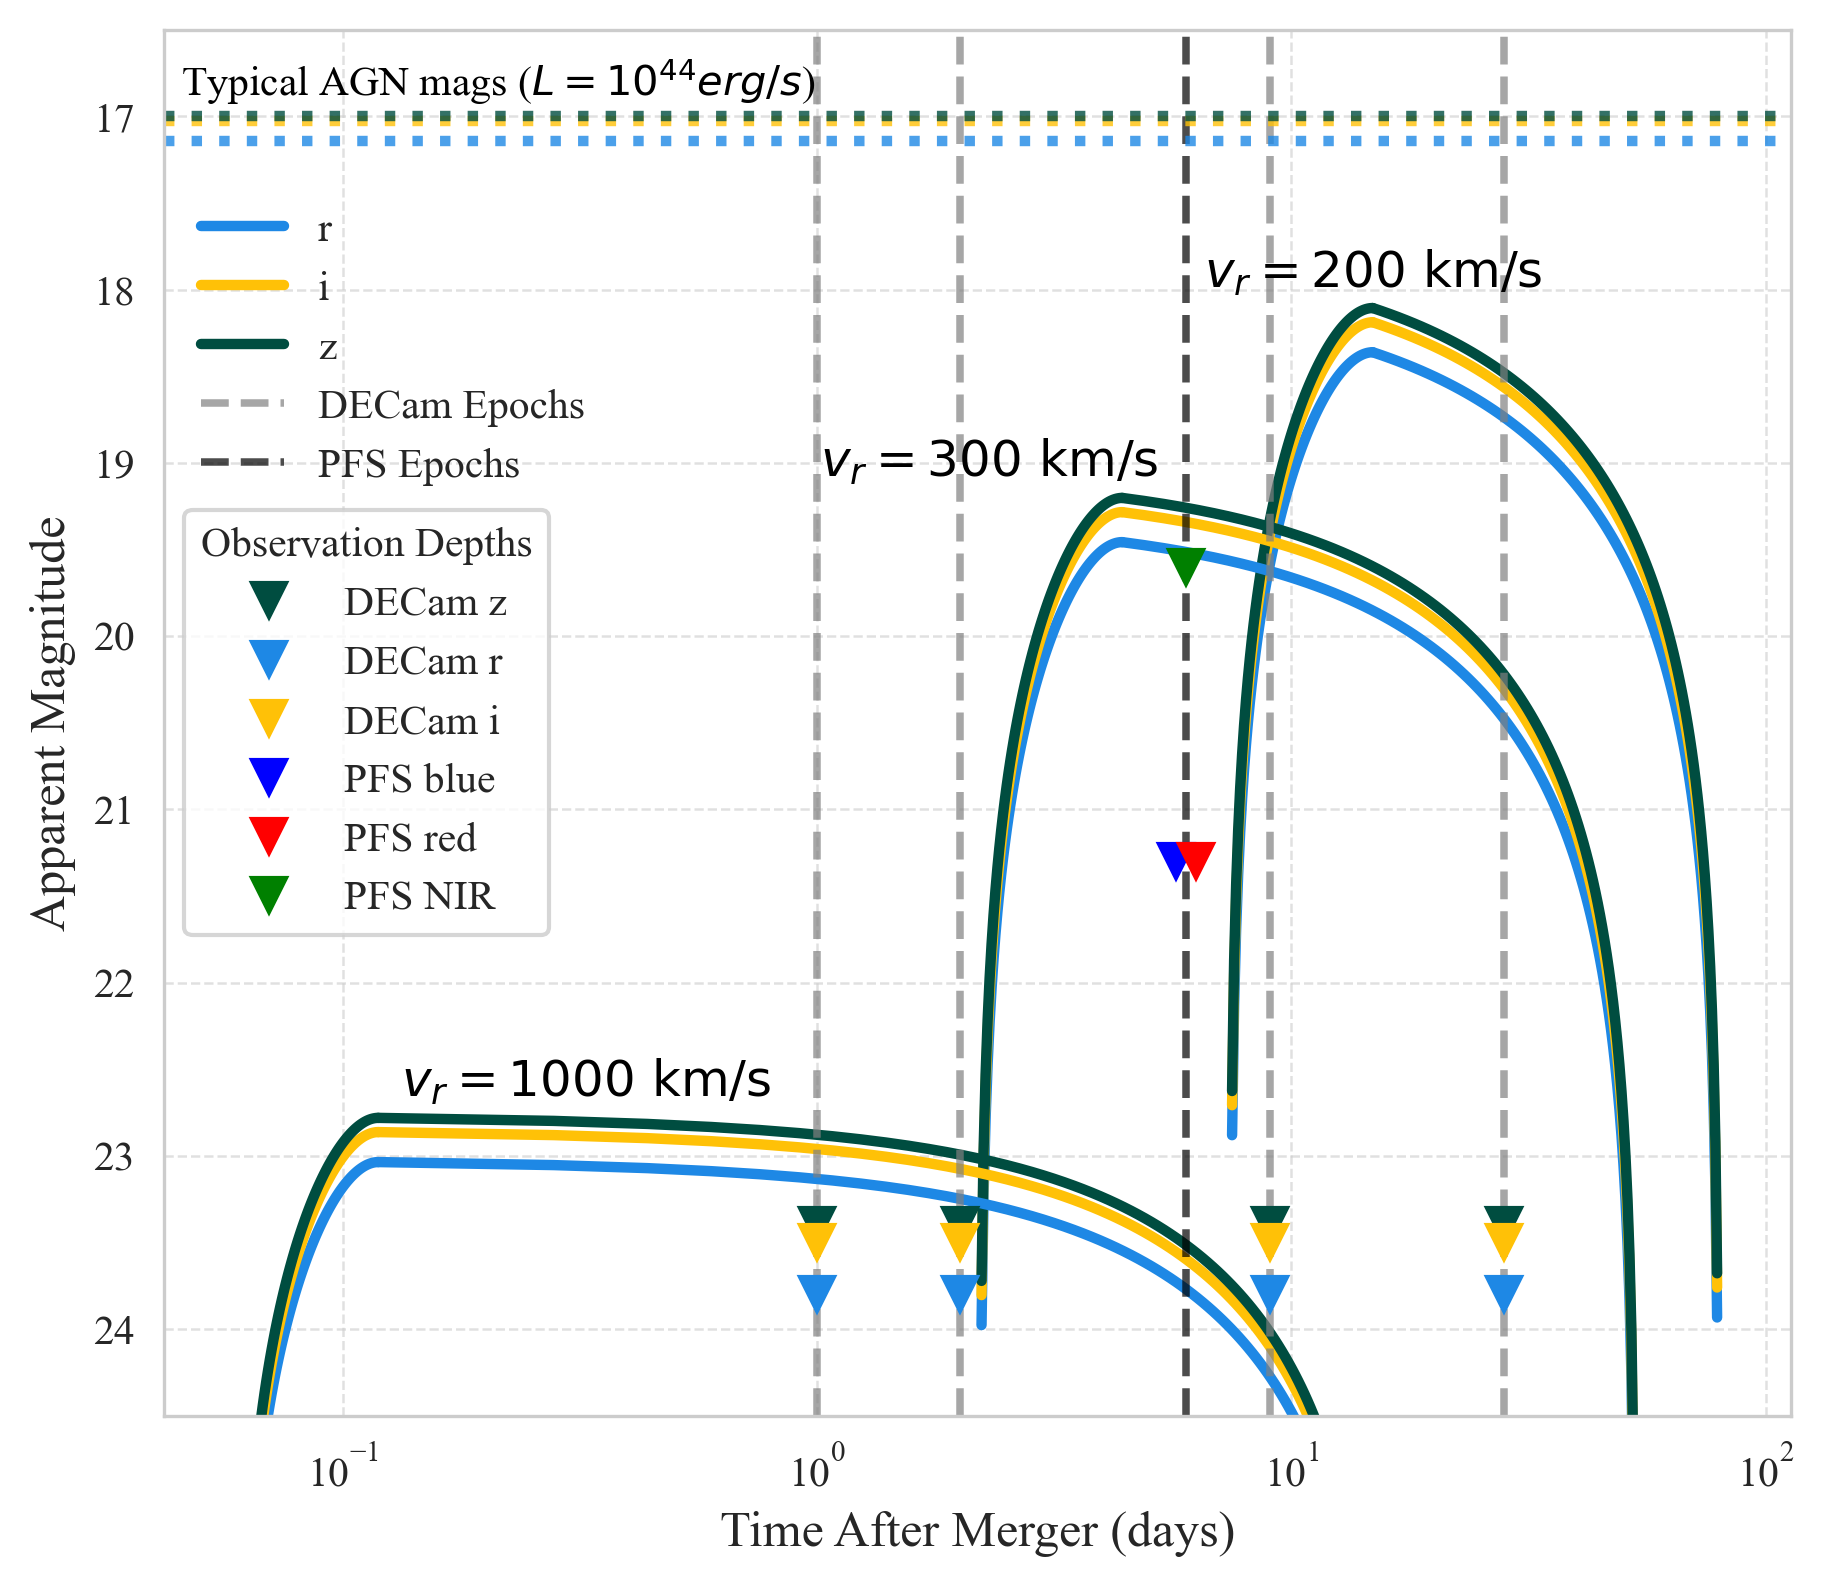

In [55]:
plt.rcParams.update({
    
    "font.family": "serif",  # or "sans-serif" or "monospace"
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

fig, ax = plt.subplots(figsize=(7, 6), dpi=300)  # 1 row, 2 columns
mask = (mag_rise_1_r_qso > 40)
ax.plot(t_rise_1, mag_rise_1_r_qso, color='#1E88E5', linewidth=2.5, label='r')#, label='Weak Kick')#, linestyle=':', )
ax.plot(t_fall_1, mag_fall_1_r_qso, color='#1E88E5', linewidth=2.5)#, linestyle=':')
ax.plot(t_rise_1, mag_rise_1_i_qso, color='#FFC107', linewidth=2.5, label='i')#, linestyle=':')
ax.plot(t_fall_1, mag_fall_1_i_qso, color='#FFC107', linewidth=2.5)#, linestyle=':')
ax.plot(t_rise_1, mag_rise_1_z_qso, color='#004D40', linewidth=2.5, label='z')#, linestyle=':')
ax.plot(t_fall_1, mag_fall_1_z_qso, color='#004D40', linewidth=2.5)#, linestyle=':')

ax.annotate(rf"$v_r = {vk1}\ \text{{km/s}}$", #\ \rho = 10^{{{np.log10(density):.1f}}}\ \text{{g/cm³}}$", 
        xy=(t_rise_1[-1], mag_rise_1_z_qso[-1]),  
        textcoords="offset points", 
        xytext=(0, 5),  
        ha='center', 
        fontsize='medium', 
        color='black')

#ax2.plot(t_rise_2, mag_rise_intermediate_g, color='#D81B60', linewidth=2.5)
#ax2.plot(t_fall_2, mag_fall_intermediate_g, color='#D81B60', linewidth=2.5)
ax.plot(t_rise_2, mag_rise_2_r_qso, color='#1E88E5', linewidth=2.5)#, label='Intermediate Kick')#, linestyle='--', label='Intermediate Kick')
ax.plot(t_fall_2, mag_fall_2_r_qso, color='#1E88E5', linewidth=2.5)#, linestyle='--')
ax.plot(t_rise_2, mag_rise_2_i_qso, color='#FFC107', linewidth=2.5)#, linestyle='--')
ax.plot(t_fall_2, mag_fall_2_i_qso, color='#FFC107', linewidth=2.5)#, linestyle='--')
ax.plot(t_rise_2, mag_rise_2_z_qso, color='#004D40', linewidth=2.5)#, linestyle='--')
ax.plot(t_fall_2, mag_fall_2_z_qso, color='#004D40', linewidth=2.5)#, linestyle='--')

ax.annotate(rf"$v_r = {vk2}\ \text{{km/s}}$", #\ \rho = 10^{{{np.log10(density):.1f}}}\ \text{{g/cm³}}$", 
        xy=(t_rise_2[-1], mag_rise_2_z_qso[-1]),  
        textcoords="offset points", 
        xytext=(-32, 5), 
        ha='center', 
        fontsize='medium', 
        color='black')

#ax2.plot(t_rise_3, mag_rise_weak_g, color='#D81B60', linewidth=2.5, label="g")
#ax2.plot(t_fall_3, mag_fall_weak_g, color='#D81B60', linewidth=2.5)
ax.plot(t_rise_3, mag_rise_3_r_qso, color='#1E88E5', linewidth=2.5)#, label="Strong Kick")#, linestyle='-.', )
ax.plot(t_fall_3, mag_fall_3_r_qso, color='#1E88E5', linewidth=2.5)
ax.plot(t_rise_3, mag_rise_3_i_qso, color='#FFC107', linewidth=2.5)#, linestyle='-.')
ax.plot(t_fall_3, mag_fall_3_i_qso, color='#FFC107', linewidth=2.5)
ax.plot(t_rise_3, mag_rise_3_z_qso, color='#004D40', linewidth=2.5)#, linestyle='-.')
ax.plot(t_fall_3, mag_fall_3_z_qso, color='#004D40', linewidth=2.5)

ax.annotate(rf"$v_r = {vk3}\ \text{{km/s}}$", #\ \rho = 10^{{{np.log10(density):.1f}}}\ \text{{g/cm³}}$", 
        xy=(t_rise_3[-1], mag_rise_3_z_qso[-1]),  
        textcoords="offset points", 
        xytext=(50, 5),  
        ha='center', 
        fontsize='medium', 
        color='black')


colors = {'g': '#D81B60', 'r': '#1E88E5', 'i': '#FFC107', 'z': '#004D40'}
for x in epochs[i]:
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=1.8, alpha=0.7, label='DECam Epochs' if x == epochs[i][0] else "")

for x in pfs_epochs_list:
    ax.axvline(x=x, color='black', linestyle='--', linewidth=1.8, alpha=0.7, label='PFS Epochs' if x == pfs_epochs_list[0] else "")
#ax2.axvline(x=0, color='black', linestyle='-', linewidth=2.5, alpha=0.8, label='Merger Time (t=0)')

# Average luminosity line


avg_lumi = 10**44
mags_agn = {}  # Sun like SED is ok for the AGN itself
for band in ["g", "r", "i", "z"]:
    M_band = luminosity_to_mag(avg_lumi, band)
    m_band = absolute_to_apparent_mag(M_band, dLs[i])
    mags_agn[band] = m_band

for band in ['r', 'i', 'z']: #['g', 'r', 'i', 'z']:
    ax.axhline(y=mags_agn[band], color=colors[band], linestyle=':', linewidth=2.5, alpha=0.8)#, label=f"Average AGN Luminosity: {band}")

ax.annotate('Typical AGN mags ($L=10^{44} erg/s$)', 
        xy=(50, mags_agn['z']),  
        textcoords="offset points", 
        xytext=(-270, 5),  
        ha='center', 
        fontsize='small', 
        color='black')



ax.set_xlabel("Time After Merger (days)", fontsize=12)
ax.set_ylabel("Apparent Magnitude", fontsize=12)
#ax.set_title(f"Magnitude Lightcurve for {event}", fontsize=14, fontweight='bold')
#ax2.legend(frameon=False)#loc='lower right')
#main_legend = ax.legend( frameon=False, fontsize='small', bbox_to_anchor=(0.34, 0.8))
main_legend = ax.legend(
    frameon=False,
    fontsize='small',
    loc='center left',            # same horizontal alignment
    bbox_to_anchor=(0.0, 0.77)  # same x, but y shifted upward
)
ax.add_artist(main_legend)  # Add this explicitly so the second legend can be added too

ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
ax.invert_yaxis() 
#ax2.set_xlim(-1, 60)
#ax2.set_xlim(0.1, 100)  # Set x-axis limits for better visibility
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim(24.5, 16.5)


#ax.set_ylim(19.1, 18.6)

# Custom tick formatter: Display original (non-log) values
#ax2.xaxis.set_major_formatter(FuncFormatter(lambda val, _: f"{val:.0f}"))

# Add major and minor ticks for better readability
#ax2.xaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=10))
#ax2.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))

# Observation depths
for x in epochs[i]:
    #print(x)
    ax.plot(x, obs_depths_decam[x]['z'], color=colors['z'], marker='v', markersize=8, label='DECam Observation Depths' if x == epochs[i][0] else "")
    ax.plot(x, obs_depths_decam[x]['r'], color=colors['r'], marker='v', markersize=8)
    ax.plot(x, obs_depths_decam[x]['i'], color=colors['i'], marker='v', markersize=8)
print("DECam epochs:", epochs[i])
print("PFS epochs:", pfs_epochs_list)
for x in pfs_epochs_list:
    offset = 0.3
    mjd_epoch = float(x[0])  # extract the scalar from array([6.])
    ax.plot(mjd_epoch - offset, obs_depths_pfs[mjd_epoch]['blue'], color='blue', marker='v', markersize=8, label='PFS Blue-band Depth')
    ax.plot(mjd_epoch + offset, obs_depths_pfs[mjd_epoch]['red'], color='red', marker='v', markersize=8, label='PFS Red-band Depth')
    ax.plot(mjd_epoch, obs_depths_pfs[mjd_epoch]['nir'], color='green', marker='v', markersize=8, label='PFS NIR Depth')

# Custom legend 
depth_legend_lines = [
    Line2D([0], [0], color=colors['z'], marker='v', linestyle='None', markersize=8, label='DECam z'),
    Line2D([0], [0], color=colors['r'], marker='v', linestyle='None', markersize=8, label='DECam r'),
    Line2D([0], [0], color=colors['i'], marker='v', linestyle='None', markersize=8, label='DECam i'),
    Line2D([0], [0], color='blue', marker='v', linestyle='None', markersize=8, label='PFS blue'),
    Line2D([0], [0], color='red', marker='v', linestyle='None', markersize=8, label='PFS red'),
    Line2D([0], [0], color='green', marker='v', linestyle='None', markersize=8, label='PFS NIR'),
]

depth_legend = ax.legend(
    handles=depth_legend_lines,
    loc='center left',          # corner inside the axes
    #bbox_to_anchor=(1, 1),      # anchor to the left side of middle
    frameon=True,
    title="Observation Depths",
    fontsize='small',
    title_fontsize='small'
)

plt.savefig(f'lightcurve_{event}.jpeg', bbox_inches='tight', dpi=600)
plt.show()